In [35]:
import pandas as pd
import requests

In [36]:
raw_data = pd.read_csv("/home/mello/stock/src/stock/extract/data/alphavatnage.csv")

In [37]:

df_raw = pd.DataFrame(raw_data)
df_raw.head()
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  350 non-null    object 
 1   open       350 non-null    float64
 2   high       350 non-null    float64
 3   low        350 non-null    float64
 4   close      350 non-null    float64
 5   volume     350 non-null    float64
dtypes: float64(5), object(1)
memory usage: 16.5+ KB


In [42]:
def transform_market_data(df: pd.DataFrame) -> pd.DataFrame:
    # Normalize column names
    df.columns = df.columns.str.lower()
    if "time" in df.columns:
        df = df.rename(columns={"time": "timestamp"})
    
    # Clean timestamp
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp")

    # Convert numeric columns safely
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    # Derived metrics
    df["price_change"] = df["close"] - df["open"]
    df["price_change_pct"] = (df["close"] - df["open"]) / df["open"] * 100
    df["high_low_range"] = df["high"] - df["low"]
    df["high_low_pct"] = (df["high"] - df["low"]) / df["low"] * 100

    # Trend indicators
    df["ma_3"] = df["close"].rolling(window=3).mean()
    df["ma_7"] = df["close"].rolling(window=7).mean()
    df["volatility_3"] = df["close"].pct_change().rolling(window=3).std() * 100

    # Date parts
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["day"] = df["timestamp"].dt.day
    df["day_of_week"] = df["timestamp"].dt.day_name()

    return df
df_transformed = transform_market_data(df)
df_transformed.info()
df_transformed.head()

<class 'pandas.core.frame.DataFrame'>
Index: 350 entries, 349 to 0
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         350 non-null    datetime64[ns]
 1   open              350 non-null    float64       
 2   high              350 non-null    float64       
 3   low               350 non-null    float64       
 4   close             350 non-null    float64       
 5   volume            350 non-null    float64       
 6   price_change      350 non-null    float64       
 7   price_change_pct  350 non-null    float64       
 8   high_low_range    350 non-null    float64       
 9   high_low_pct      350 non-null    float64       
 10  ma_3              348 non-null    float64       
 11  ma_7              344 non-null    float64       
 12  volatility_3      347 non-null    float64       
 13  year              350 non-null    int32         
 14  month             350 non-null 

,timestamp,open,high,low,close,volume,price_change,price_change_pct,high_low_range,high_low_pct,ma_3,ma_7,volatility_3,year,month,day,day_of_week
349,2024-11-11,74780.73,82900.00,74639.10,82274.06,1441.286148,7493.33,10.020402,8260.90,11.067792,NaN,NaN,NaN,2024,11,11,Monday
348,2024-11-12,82273.98,84457.98,75700.00,82334.41,1838.122623,60.43,0.073450,8757.98,11.569326,NaN,NaN,NaN,2024,11,12,Tuesday
347,2024-11-13,82311.26,88000.00,80903.15,85278.66,1364.449611,2967.40,3.605096,7096.85,8.772032,83295.710000,NaN,NaN,2024,11,13,Wednesday
346,2024-11-14,85286.00,87076.83,82317.57,82917.20,877.498464,-2368.80,-2.777478,4759.26,5.781585,83510.090000,NaN,3.178256,2024,11,14,Thursday
345,2024-11-15,82893.06,87076.83,82621.18,86260.52,532.441879,3367.46,4.062415,4455.65,5.392867,84818.793333,NaN,3.801859,2024,11,15,Friday


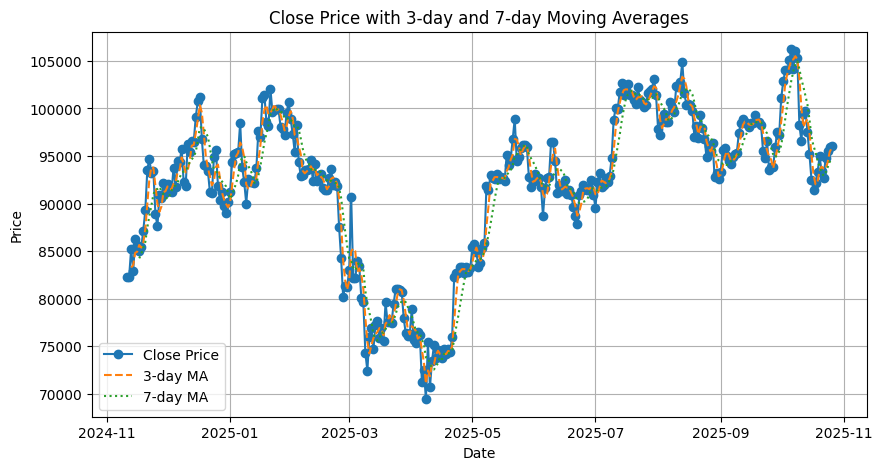

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_transformed["timestamp"], df_transformed["close"], label="Close Price", marker="o")
plt.plot(df_transformed["timestamp"], df_transformed["ma_3"], label="3-day MA", linestyle="--")
plt.plot(df_transformed["timestamp"], df_transformed["ma_7"], label="7-day MA", linestyle=":")
plt.title("Close Price with 3-day and 7-day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

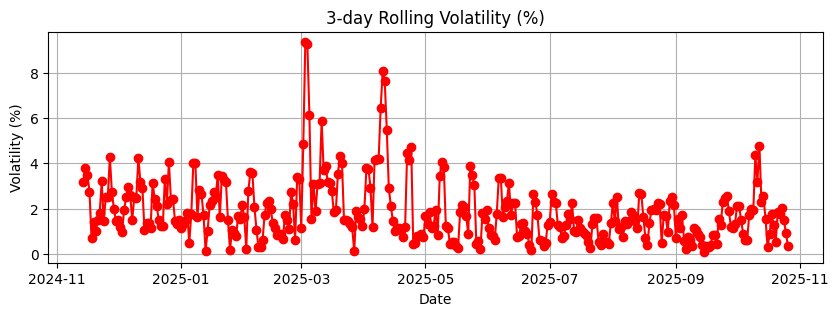

In [46]:
plt.figure(figsize=(10, 3))
plt.plot(df_transformed["timestamp"], df_transformed["volatility_3"], color="red", marker="o")
plt.title("3-day Rolling Volatility (%)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.grid(True)
plt.show()